In [1]:
# ============================================
# 1. Imports
# ============================================
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)
from xgboost import XGBClassifier

In [2]:
# ============================================
# 2. Load Data
# ============================================
df_encoded = pd.read_csv('../data/cleaned_credit_data.csv')
print(f"Number of rows: {df_encoded.shape[0]}")

# Sample 500,000 rows for training
df_sample = df_encoded.sample(n=500000, random_state=42)

Number of rows: 1345310


In [3]:
# ============================================
# 3. Features & Target
# ============================================
X = df_sample.drop('default', axis=1)
y = df_sample['default']


In [4]:
# ============================================
# 4. Clean Column Names for XGBoost
# ============================================
def clean_cols(index):
    idx = pd.Index(index).astype(str)
    idx = idx.str.replace(r'\[', '', regex=True) \
             .str.replace(r'\]', '', regex=True) \
             .str.replace('<', 'LT', regex=False) \
             .str.replace('>', 'GT', regex=False) \
             .str.replace(r'\s+', '_', regex=True)
    return idx

X.columns = clean_cols(X.columns)

In [5]:
# ============================================
# 5. Train/Validation/Test Split
# ============================================
# First split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Then split train+val into train and validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)

print(f"Train: {X_tr.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (320000, 867), Val: (80000, 867), Test: (100000, 867)


In [6]:
# ============================================
# 6. Handle Class Imbalance
# ============================================
scale_pos_weight = (y_tr == 0).sum() / (y_tr == 1).sum()
print(f"Scale_pos_weight: {scale_pos_weight:.2f}")


Scale_pos_weight: 4.02


In [7]:
# ============================================
# 7. Train XGBoost
# ============================================
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

start = time.time()
xgb.fit(X_tr, y_tr)
train_time = time.time() - start
print(f"Training time: {train_time:.2f} seconds")

Training time: 27.63 seconds


In [8]:
# ============================================
# 8. Evaluate on Test Set
# ============================================
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

Confusion Matrix:
[[56619 23455]
 [ 7726 12200]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.78     80074
           1       0.34      0.61      0.44     19926

    accuracy                           0.69    100000
   macro avg       0.61      0.66      0.61    100000
weighted avg       0.77      0.69      0.72    100000

ROC AUC Score: 0.7238


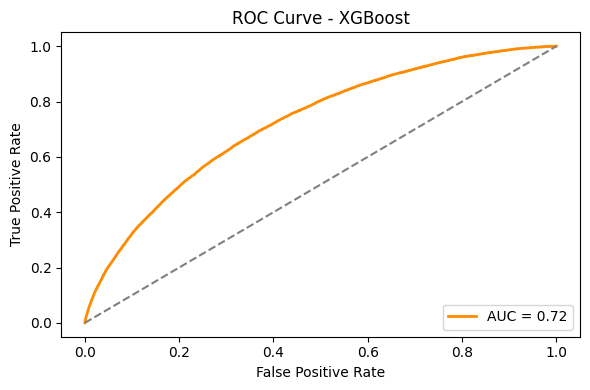

In [9]:
# ============================================
# 9. ROC Curve Plot
# ============================================
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_val:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()